In [28]:
"""
Description
"""

import os, time
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
import rasterio as rio
from rasterstats import zonal_stats
import pandas as pd
import numpy as np

maindir = '/Users/max/OneDrive/mcook/data/'
projdir = '/Users/max/OneDrive/mcook/earth-lab/hyr-sense/'

proj = 'EPSG:32613'

print("Success!")

Success!


## Identify agricultural parcels from Boulder County Parks & Open Space

In the first section, we need to identify public lands that are primarily agriculture/cultivated. This step could be included in the notebook as a way of performing some basic spatial analysis / data downloading, or we could simply provide the data and let folks get right into the EMIT/ECOSTRESS data.

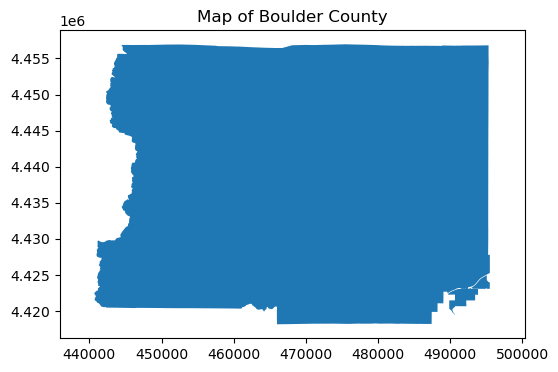

In [2]:
# Load the Boulder County shapefile
boco = gpd.read_file(os.path.join(maindir,"boundaries/political/TIGER/tl19_us_counties_conus.gpkg"))
boco = boco[boco['GEOID'] == '08013']
boco = boco.to_crs(proj)

# Map
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
boco.plot(ax=ax)
ax.set_title('Map of Boulder County')
plt.axis('equal')  # Adjust the aspect ratio
plt.show()

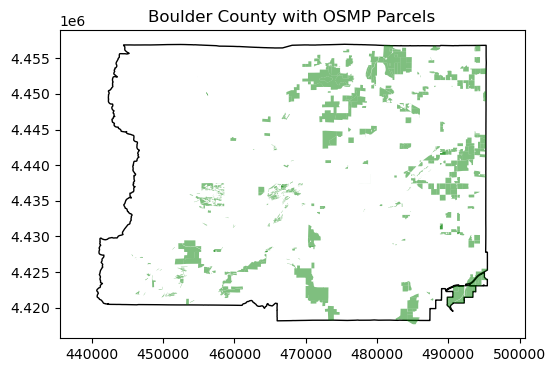

In [3]:
# Load the public lands data from USGS for Boulder County OSMP, create a map
# USGS Protected Areas Database of the United States (PADUS)
padus = os.path.join(maindir,"landowner/PADUS3_0_Region_7_GeoPackage/PADUS3_0Region7.gpkg")
padus = gpd.read_file(padus,layer="PADUS3_0Combined_Region7")

# Filter to Boulder County OSMP
osmp = padus[padus['Loc_Own'] == "Boulder County Parks & Open Space"]
osmp = osmp.to_crs(proj)
    
# Mapping
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
boco.plot(ax=ax, color='white', edgecolor='black')  # Plot Boulder County
osmp.plot(ax=ax, color='green', alpha=0.5)  # Overlay OSMP parcels

# Optional: Customize the plot
ax.set_title('Boulder County with OSMP Parcels')
plt.axis('equal')  # Adjust the aspect ratio

plt.show()

/opt/miniconda3/envs/hyr-sense/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<xarray.DataArray (y: 1289, x: 1819)> Size: 2MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 15kB 4.407e+05 4.407e+05 ... 4.954e+05 4.955e+05
  * y            (y) float64 10kB 4.457e+06 4.457e+06 ... 4.418e+06 4.418e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:           Area
    LAYER_TYPE:              thematic
    long_name:               Layer_1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        E
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0
Unique pixel values: [0 1 2]


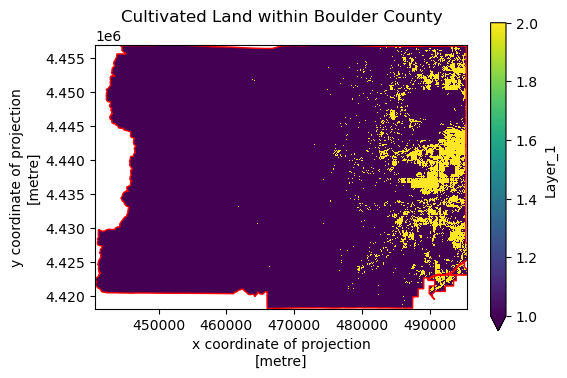

In [4]:
# Load the NASS Cropland Data Layer cultivated mask (binary), create a map
fpath = os.path.join(projdir,"data/spatial/boulder_county_cultivated.tif")
cultivated = rxr.open_rasterio(fpath, masked=True).squeeze().astype(np.uint8)
print(cultivated)

# Reproject the raster data to 'EPSG:32613'
cultivated = cultivated.rio.reproject("EPSG:32613")
values = cultivated.values.flatten()
unique_values = np.unique(values)
print("Unique pixel values:", unique_values)

# Clip to Boulder County
cultivated = cultivated.rio.clip(boco.geometry).astype(np.uint8)
cultivated = cultivated.where(cultivated != 255)
# Save the file out
cultivated.rio.to_raster(fpath)

# Map
fig, ax = plt.subplots(figsize=(6, 4))
cultivated.plot(
    ax=ax,
    cmap='viridis',  # or any suitable colormap
    vmin=1, vmax=2,  # Set min and max values to display
    add_colorbar=True  # Optionally add a colorbar to show mapping from values to colors
)
boco.boundary.plot(ax=ax, color='red', linewidth=1)
ax.set_title("Cultivated Land within Boulder County")
plt.show()

   uid    1.0  count  majority  2.0  0.0
0    1  349.0    349       1.0  NaN  NaN
1    2  665.0    665       1.0  NaN  NaN
2    3  556.0    556       1.0  NaN  NaN
3    4  142.0    142       1.0  NaN  NaN
4    5    5.0      5       1.0  NaN  NaN


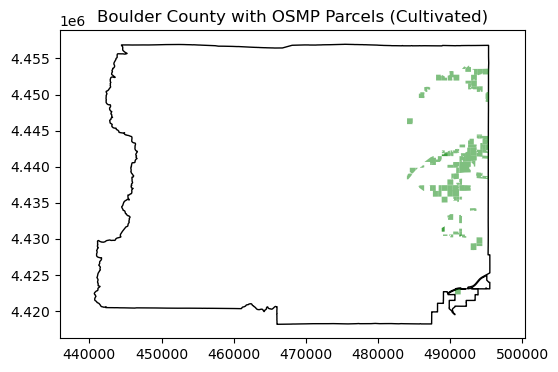

In [5]:
# Run a zonal statistics to identify Boulder County OSMP properties that are primary cultivated

# Add a unique ID
osmp.loc[:, 'uid'] = range(1, len(osmp) + 1)

# Keep only needed columns
osmp = osmp[['uid','geometry']]

# Run the zonal statistics
stats = zonal_stats(
    osmp, fpath, 
    stats="count majority", 
    categorical=True, 
    affine=cultivated.rio.transform(), 
    nodata=255,
    geojson_out=True
)

# Extract the results as a dataframe
stats_df = pd.DataFrame([feature['properties'] for feature in stats])
print(stats_df.head())

# Retain parcel that are predominantly cultivated
stats_df = stats_df[stats_df['majority'] == 2.0]
uids = stats_df['uid'].tolist()
osmp_cultivated = osmp[osmp['uid'].isin(uids)]

# Create a map of cultivate parcels
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
boco.plot(ax=ax, color='white', edgecolor='black')  # Plot Boulder County
osmp_cultivated.plot(ax=ax, color='green', alpha=0.5)  # Overlay OSMP parcels

# Optional: Customize the plot
ax.set_title('Boulder County with OSMP Parcels (Cultivated)')
plt.axis('equal')  # Adjust the aspect ratio

plt.show()

## Find data from EMIT overlapping parcel data

In [6]:
import earthaccess
earthaccess.login(persist=True)

In [7]:
Query = earthaccess.collection_query().keyword('emit').provider('LPCLOUD')
print(f'Collections found: {Query.hits()}')

Collections found: 7


In [8]:
# Find Collections
collections = Query.fields(['ShortName']).get(4)
# Retrieve Collection Short-names
[product['short-name'] for product in [collection.summary() for collection in collections]]

['EMITL2ARFL', 'EMITL2BCH4ENH', 'EMITL2BCH4PLM', 'EMITL2BMIN']

In [9]:
# ~ Extract a list coordinate pairs for each parcel ~

# First, reproject to WGS84 for coordinates are in degrees
osmp_cultivated = osmp_cultivated.to_crs(epsg=4326)

# Extract the coordinate pairs
uids = []
coord_lists = []
for index, row in osmp_cultivated.iterrows():
    uids.append(row['uid'])
    coord_lists.append(row['geometry'].bounds)

# Check the results
print(coord_lists[0])
print(uids[0])

(-105.10233766943327, 40.069230376649045, -105.09797109450328, 40.07284651675156)
126


In [11]:
# Loop through bounds, search for and record # of EMIT scenes

results = [] # to store the output jsons

for i in range(len(coord_lists)):
    # Extract the bounding coordinates
    coords = coord_lists[i]
    # Search for EMIT data
    search_results = earthaccess.search_data(
        short_name='EMITL2ARFL',
        bounding_box=coords,
        temporal=('2023-05-01','2023-09-28'),
        count=100
    )
    # Extract the json as data frame
    search_df = pd.json_normalize(search_results)
    search_df['uid'] = uids[i] # add the parcel ID
    results.append(search_df)

results[0].head()

Granules found: 3
Granules found: 1
Granules found: 3
Granules found: 3
Granules found: 2
Granules found: 4
Granules found: 4
Granules found: 4
Granules found: 4
Granules found: 3
Granules found: 3
Granules found: 1
Granules found: 3
Granules found: 1
Granules found: 3
Granules found: 1
Granules found: 3
Granules found: 4
Granules found: 4
Granules found: 1
Granules found: 1
Granules found: 2
Granules found: 1
Granules found: 2
Granules found: 4
Granules found: 3
Granules found: 1
Granules found: 1
Granules found: 1
Granules found: 3
Granules found: 3
Granules found: 1
Granules found: 1
Granules found: 4
Granules found: 3
Granules found: 3
Granules found: 3
Granules found: 1
Granules found: 1
Granules found: 1
Granules found: 1
Granules found: 4
Granules found: 3
Granules found: 1
Granules found: 2
Granules found: 3
Granules found: 4
Granules found: 1
Granules found: 3
Granules found: 3
Granules found: 1
Granules found: 3
Granules found: 3
Granules found: 1
Granules found: 1
Granules f

,size,meta.concept-type,meta.concept-id,meta.revision-id,meta.native-id,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,umm.TemporalExtent.RangeDateTime.BeginningDateTime,...,umm.RelatedUrls,umm.CloudCover,umm.DataGranule.DayNightFlag,umm.DataGranule.ArchiveAndDistributionInformation,umm.DataGranule.ProductionDateTime,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version,uid
0,3577.205499,granule,G2715759107-LPCLOUD,2,EMIT_L2A_RFL_001_20230602T194102_2315313_019,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-24T22:47:38.272Z,2023-06-02T19:41:02Z,...,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,95,Day,[{'Name': 'EMIT_L2A_RFL_001_20230602T194102_23...,2023-06-18T00:35:08Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,126
1,3581.195470,granule,G2736967625-LPCLOUD,1,EMIT_L2A_RFL_001_20230625T170814_2317611_005,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-07-22T10:14:06.135Z,2023-06-25T17:08:14Z,...,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,8,Day,[{'Name': 'EMIT_L2A_RFL_001_20230625T170814_23...,2023-07-22T09:38:22Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,126
2,3580.524246,granule,G2736968331-LPCLOUD,1,EMIT_L2A_RFL_001_20230625T170826_2317611_006,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-07-22T10:14:28.838Z,2023-06-25T17:08:26Z,...,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,21,Day,[{'Name': 'EMIT_L2A_RFL_001_20230625T170826_23...,2023-07-22T09:38:34Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,126


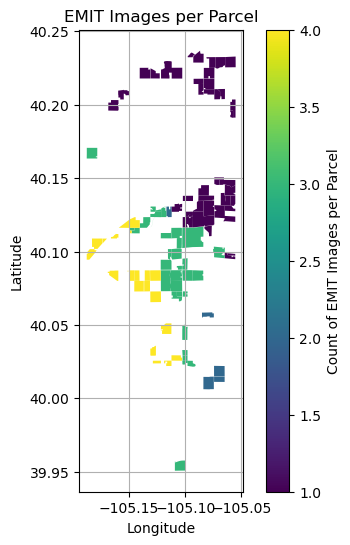

In [15]:
# Concatenate the list of lists
results_df = pd.concat(results)
results_df.head()

# Get an image count for each parcel
image_count = results_df.groupby('uid').size().reset_index(name='image_count')
# Join to the spatial data
osmp_count = osmp_cultivated.merge(image_count, on='uid', how='right')

# Create a map
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
osmp_count.plot(column='image_count', ax=ax, legend=True,
                     legend_kwds={'label': "Count of EMIT Images per Parcel"},
                     cmap='viridis')  # Use a colormap that reflects quantity (like 'viridis' or 'plasma')
plt.title('EMIT Images per Parcel')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [16]:
# Join the metadata to the spatial data
osmp_cultivated = osmp_cultivated.merge(results_df, left_on='uid', right_on='uid', how='right')
print(osmp_cultivated.columns)

Index(['uid', 'geometry', 'size', 'meta.concept-type', 'meta.concept-id',
       'meta.revision-id', 'meta.native-id', 'meta.collection-concept-id',
       'meta.provider-id', 'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime', 'umm.GranuleUR',
       'umm.AdditionalAttributes',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEName',
       'umm.PGEVersionClass.PGEVersion', 'umm.RelatedUrls', 'umm.CloudCover',
       'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.ArchiveAndDistributionInformation',
       'umm.DataGranule.ProductionDateTime', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version'],
      dtype='object')


## Filter by metadata attributes, retrieve list of tile IDs for download

In [21]:
# Filter to remove cloudy scenes
med_clouds = osmp_cultivated[osmp_cultivated['umm.CloudCover'] < 50]
low_clouds = osmp_cultivated[osmp_cultivated['umm.CloudCover'] < 10]

print("Parcels with at least one image < 50% cloud cover: "+str(len(med_clouds['uid'].unique())))
print("Parcels with at least one image < 10% cloud cover: "+str(len(low_clouds['uid'].unique())))

Parcels with at least one image < 50% cloud cover: 55
Parcels with at least one image < 10% cloud cover: 44


In [25]:
# Get a list of granules from the "medium cloud" parcels
granule_list = med_clouds['meta.native-id'].unique()
print(granule_list)

# Create the granule download path
granule_list_d = []
for granule in granule_list:
    ncpath = granule+"/"+granule+".nc"
    granule_list_d.append(ncpath)
print(granule_list_d)

['EMIT_L2A_RFL_001_20230625T170814_2317611_005'
 'EMIT_L2A_RFL_001_20230625T170826_2317611_006']
['EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc', 'EMIT_L2A_RFL_001_20230625T170826_2317611_006/EMIT_L2A_RFL_001_20230625T170826_2317611_006.nc']


In [30]:
# Get Https Session using Earthdata Login Info
fs = earthaccess.get_fsspec_https_session()

# Base download URL
base_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001'

# Define local storage location on CyVerse - default is HYR-SENSE/data/emit
loc_file_path = os.path.join(projdir,'data/emit/')

In [ ]:
# Download the data granules
t0 = time.time()
for i in range(len(granule_list_d)):
    print("Granule ID: " + granule_list_d[i].split('/')[1])
    granule_asset_id = granule_list_d[i].split('/')[1]
    out_path = loc_file_path + f'{granule_asset_id}'
    # Download the Granule Asset if it doesn't exist
    url = os.path.join(base_url,granule_list_d[i])
    if not os.path.isfile(out_path):
        fs.download(url, out_path)
print('Total time:', time.time() - t0)

Granule ID: EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc
Granule ID: EMIT_L2A_RFL_001_20230625T170826_2317611_006.nc
